## 0 - Librairies

In [14]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Masking, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

## 1 - Data Preparation

In [15]:
train_df = pd.read_csv("Swissprot_Train_Validation_dataset.csv")

In [16]:
labels = train_df.drop(columns=["ACC", "Sequence", "Kingdom", "Unnamed: 0", "Partition"]).values

In [17]:
amino_acids = sorted(set(''.join(train_df["Sequence"])))
aa_to_index = {aa: i+1 for i, aa in enumerate(amino_acids)}  # +1  (0 reserved to padding)
vocab_size = len(amino_acids) + 1  # +1 for padding

In [18]:
# Function to transform and encode a sequence in one pass
def transform_and_encode_sequence(sequence, aa_to_index, max_length=1000):
    """
    Transform and encode a sequence of amino acids according to the following rules:
    - If the sequence is shorter than max_length, pad with zeros.
    - If the sequence is longer than max_length, keep the first 500 and last 500 amino acids.
    """
    # Encode sequence as indices
    encoded = np.array([aa_to_index.get(aa, 0) for aa in sequence], dtype=np.int32)

    # Transform sequence
    if len(encoded) < max_length:
        # Pad with zeros
        transformed = np.zeros(max_length, dtype=np.int32)
        transformed[:len(encoded)] = encoded
    else:
        # Keep first 500 and last 500 amino acids
        transformed = np.concatenate([encoded[:500], encoded[-500:]])

    return transformed

In [19]:
# Apply transformation and encoding directly to sequences
X = np.array([transform_and_encode_sequence(seq, aa_to_index) for seq in train_df["Sequence"]])

In [20]:
print("Shape of X:", X.shape)
print("Example of transformed sequence:\n", X[0, :10])

Shape of X: (28303, 1000)
Example of transformed sequence:
 [12  1  1  1  1  1  1  1  1  1]


In [21]:
print("Shape of y:", labels.shape)
print("Example of labels:\n", labels[0])

Shape of y: (28303, 11)
Example of labels:
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## 2 - Modele LSTM


### Parameters

In [22]:
test_size = 0.2
embedding_dim = 32
epochs = 50
loss = 'binary_crossentropy'
metrics = ['accuracy']
monitor_callback = "val_accuracy"
patience_callback = 4
mode_callback = None #"max"

In [23]:
# Split data into training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=test_size)

In [24]:
param_grid = {
    'learning_rate': [0.001],
    'dropout_rate': [0.2],   #   [0.2, 0.3]
    'batch_size': [32]    #   [32, 64]
}

In [25]:
def create_and_train_model(X_train, y_train, learning_rate, dropout_rate, batch_size, epochs):
    model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=1000,
        mask_zero=True
    ),
    Masking(mask_value=0.0),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(dropout_rate),
    Bidirectional(LSTM(64)),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),  # Ajoute une couche dense intermédiaire
    Dense(11, activation='sigmoid')
])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        verbose=1,
        callbacks=[EarlyStopping(monitor=monitor_callback, patience=patience_callback, mode=mode_callback, restore_best_weights=True)]
    )
    return model, history

In [26]:
best_score = -np.inf
best_params = {}
best_model = None
best_history = None

# Grid search but manually (GridSearch does not work...)
for learning_rate in param_grid['learning_rate']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:

              print(f"Testing: lr={learning_rate}, dropout={dropout_rate}, batch_size={batch_size}")

              model, history = create_and_train_model(X_train, y_train, learning_rate, dropout_rate, batch_size, epochs)
              val_accuracy = history.history['val_accuracy'][-1]

              if val_accuracy > best_score:
                  best_score = val_accuracy
                  best_model = model
                  best_history = history

                  best_params = {
                      'learning_rate': learning_rate,
                      'dropout_rate': dropout_rate,
                      'batch_size': batch_size
                    }

Testing: lr=0.001, dropout=0.2, batch_size=32
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/tmp/ipython-input-2893793815.py:28: UserWarning: EarlyStopping mode None is unknown, fallback to auto mode.
  callbacks=[EarlyStopping(monitor=monitor_callback, patience=patience_callback, mode=mode_callback, restore_best_weights=True)]


567/567 ━━━━━━━━━━━━━━━━━━━━ 79s 133ms/step - accuracy: 0.2990 - loss: 0.3631 - val_accuracy: 0.4202 - val_loss: 0.3126
Epoch 2/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 72s 127ms/step - accuracy: 0.4531 - loss: 0.2947 - val_accuracy: 0.5039 - val_loss: 0.2679
Epoch 3/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 72s 127ms/step - accuracy: 0.5308 - loss: 0.2685 - val_accuracy: 0.4624 - val_loss: 0.2934
Epoch 4/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 72s 127ms/step - accuracy: 0.5228 - loss: 0.2665 - val_accuracy: 0.5456 - val_loss: 0.2574
Epoch 5/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 72s 128ms/step - accuracy: 0.5541 - loss: 0.2623 - val_accuracy: 0.5966 - val_loss: 0.2554
Epoch 6/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 72s 127ms/step - accuracy: 0.5674 - loss: 0.2525 - val_accuracy: 0.6023 - val_loss: 0.2468
Epoch 7/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 73s 129ms/step - accuracy: 0.5363 - loss: 0.2632 - val_accuracy: 0.5694 - val_loss: 0.2479
Epoch 8/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 73s 128ms/step - accuracy: 0.5654 - loss: 0.2520 - val

## 3 - Results

In [27]:
print(f"Best validation score: {best_score:.4f}")
print(f"Best parameters: {best_params}")

Best validation score: 0.6427
Best parameters: {'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


In [28]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1000, 32)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_1 (Masking)             │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 1000, 256)      │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1000, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,016,867 (3.88 MB)

 Trainable params: 338,955 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 677,912 (2.59 MB)

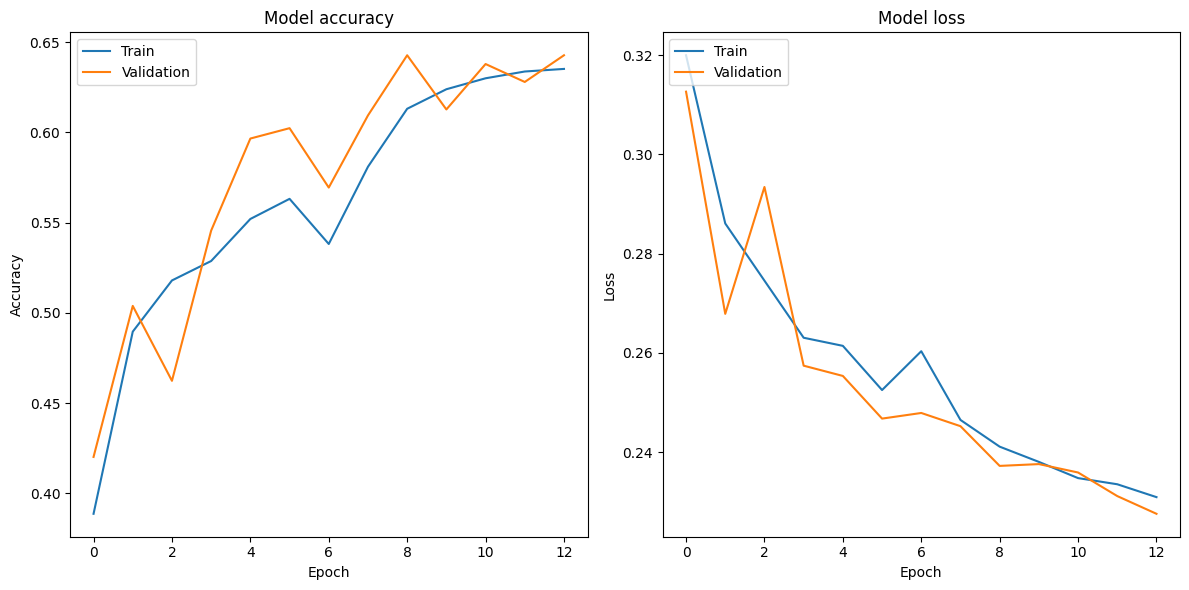

In [29]:
# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [30]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.2376
Test Accuracy: 0.6239


In [31]:
# Predict classes using the cnn model
y_pred_cnn = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)

177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step


Metrics for Class 0:


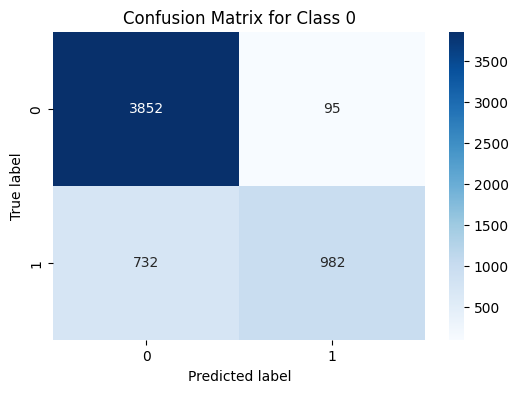

  Sensitivity (SEV): 0.5729
  Specificity (SPE): 0.9759
  Accuracy: 0.8539
  F1-score: 0.7037

Metrics for Class 1:


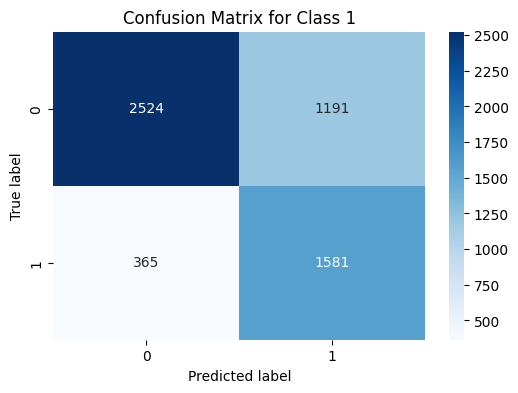

  Sensitivity (SEV): 0.8124
  Specificity (SPE): 0.6794
  Accuracy: 0.7251
  F1-score: 0.6702

Metrics for Class 2:


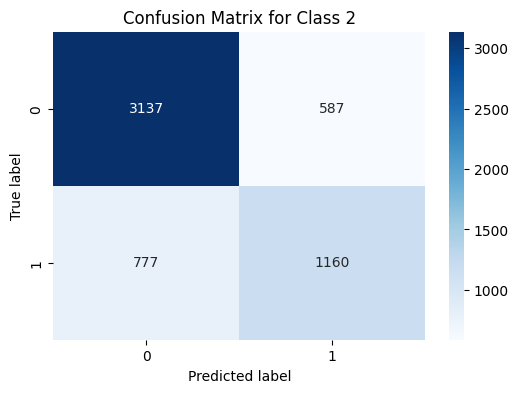

  Sensitivity (SEV): 0.5989
  Specificity (SPE): 0.8424
  Accuracy: 0.7591
  F1-score: 0.6298

Metrics for Class 3:


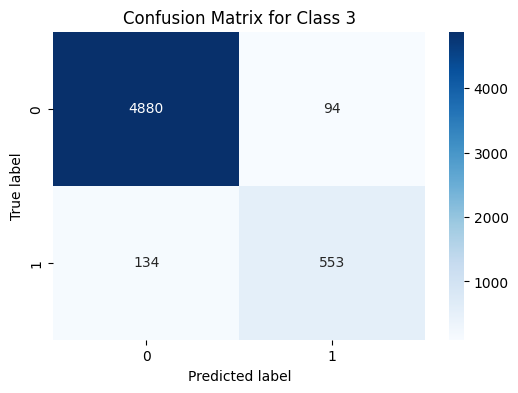

  Sensitivity (SEV): 0.8049
  Specificity (SPE): 0.9811
  Accuracy: 0.9597
  F1-score: 0.8291

Metrics for Class 4:


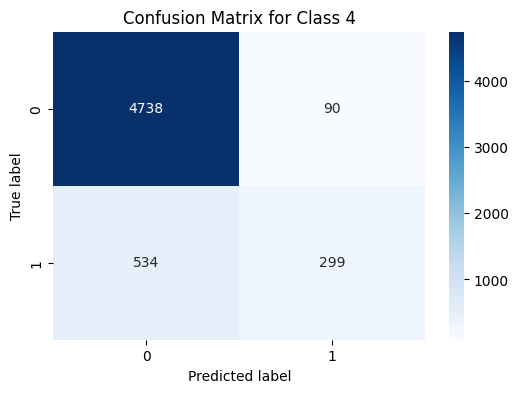

  Sensitivity (SEV): 0.3589
  Specificity (SPE): 0.9814
  Accuracy: 0.8898
  F1-score: 0.4894

Metrics for Class 5:


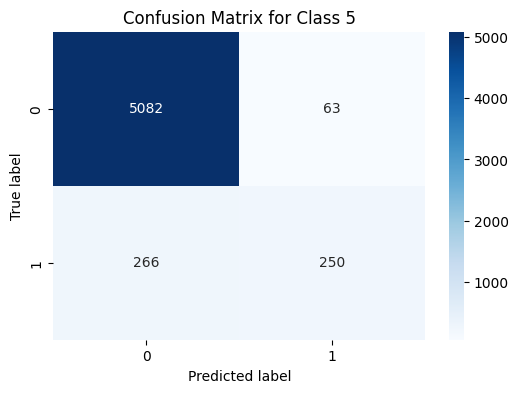

  Sensitivity (SEV): 0.4845
  Specificity (SPE): 0.9878
  Accuracy: 0.9419
  F1-score: 0.6031

Metrics for Class 6:


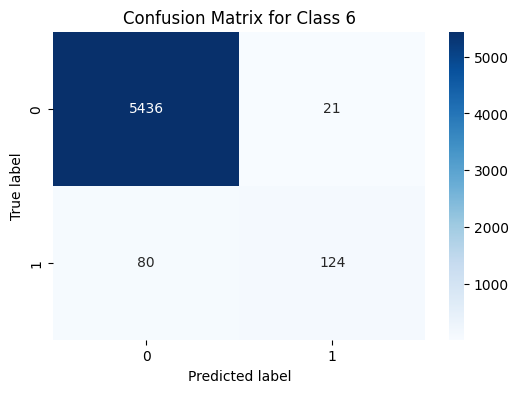

  Sensitivity (SEV): 0.6078
  Specificity (SPE): 0.9962
  Accuracy: 0.9822
  F1-score: 0.7106

Metrics for Class 7:


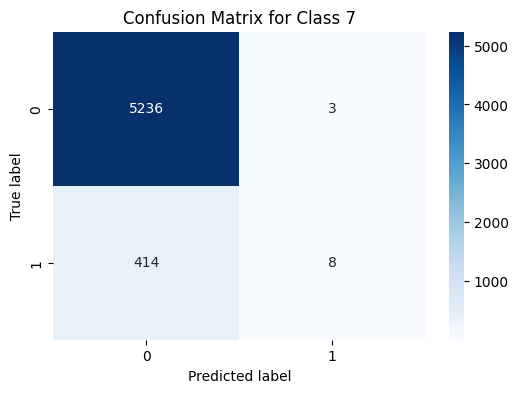

  Sensitivity (SEV): 0.0190
  Specificity (SPE): 0.9994
  Accuracy: 0.9263
  F1-score: 0.0370

Metrics for Class 8:


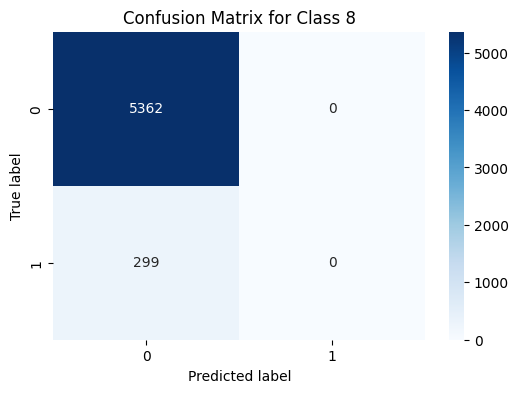

  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9472
  F1-score: 0.0000

Metrics for Class 9:


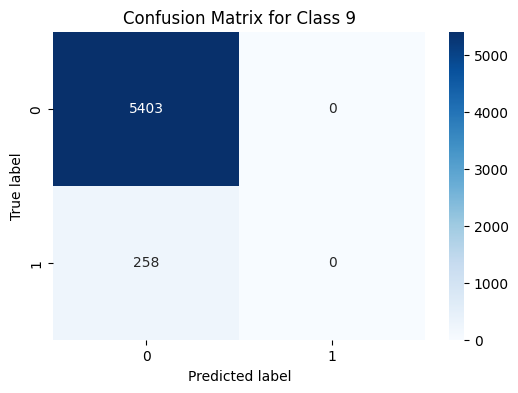

  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9544
  F1-score: 0.0000

Metrics for Class 10:


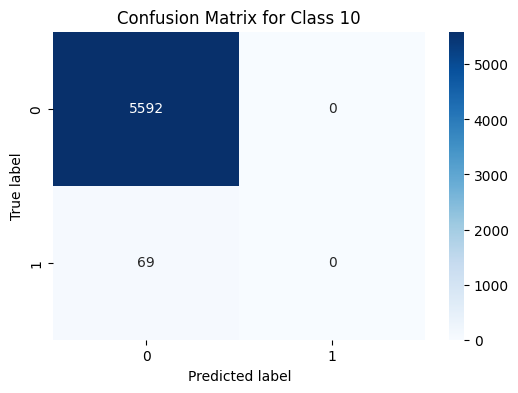

  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9878
  F1-score: 0.0000



In [33]:
# Confusion matrix
# The confusion_matrix function is designed for multiclass or binary classification,
# but y_test is a multilabel-indicator format.
# To handle this, we will calculate metrics for each class separately.

y_test_np = np.array(y_test)

for i in range(y_test_np.shape[1]):  # Iterate over each class
    print(f'Metrics for Class {i}:')
    # Extract true and predicted labels for the current class
    y_true_class = y_test_np[:, i]
    y_pred_class = y_pred_cnn[:, i] > 0.5  # Assuming a threshold of 0.5 for prediction

    # Calculate confusion matrix for the current class
    # Ensure that we have both positive and negative samples in the test set for the class
    if np.sum(y_true_class) > 0 and np.sum(1 - y_true_class) > 0:
        matrix = confusion_matrix(y_true_class, y_pred_class)

        # Plot confusion matrix for the current class
        plt.figure(figsize=(6, 4))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(f'Confusion Matrix for Class {i}')
        plt.show()

        # Calculate Sensitivity (SEV) and Specificity (SPE)
        tn, fp, fn, tp = matrix.ravel()
        f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
        sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
        spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
        accuracy = (tn + tp) / (tp + fn + tn + fp)

        print(f'  Sensitivity (SEV): {sev:.4f}')
        print(f'  Specificity (SPE): {spe:.4f}')
        print(f'  Accuracy: {accuracy:.4f}')
        print(f'  F1-score: {f1:.4f}\n')
    else:
        print(f"  Skipping metrics for Class {i} as there are no positive or negative samples in the test set.\n")